# RAG Agent w/ Routing, Grading, Fallback & Self-correction

The idea of a RAG agent comes from combination of the following three elements into a single RAG Agent:

1. **Routing** --> Route questions to different retrieval approaches
2. **Grading** --> Re-rank search results using Reciprical Rank Fusion (RRF)
2. **WebSearch Fallback** --> Fallback to web search if there are no relevant documents to query 
3. **Self-correction** --> Minimization of hallucinations



In [23]:
# import modules

from langchain.text_splitter import NLTKTextSplitter
from langchain.document_loaders import PyPDFLoader
from langchain_community.vectorstores import Chroma
from langchain.embeddings.sentence_transformer import SentenceTransformerEmbeddings
from langchain.prompts import PromptTemplate
from langchain_community.chat_models import ChatOllama
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser

import os

# Azure OpenAI
from langchain_openai import AzureChatOpenAI

In [2]:
# OpenAI

AZURE_OPENAI_API_KEY = os.environ.get("AZURE_OPENAI_API_KEY")
AZURE_OPENAI_ENDPOINT = os.environ.get('AZURE_OPENAI_ENDPOINT')
AZURE_OPENAI_VERSION = os.environ.get('AZURE_OPENAI_VERSION')
AZURE_OPENAI_DEPLOYMENT_NAME = os.environ.get('AZURE_OPENAI_DEPLOYMENT_NAME')

In [3]:
# load "cliamte change" data from /data/rag-agent-data

data_path = "data/rag-agent-data"
pdf_files = [f for f in os.listdir(data_path) if f.endswith('.pdf')]
docs = [PyPDFLoader(os.path.join(data_path, file)).load() for file in pdf_files]

print("Total documents: ", len(docs))
print(docs[2][0].page_content)

Total documents:  7
Earth Syst. Sci. Data, 15, 2295–2327, 2023
https://doi.org/10.5194/essd-15-2295-2023
© Author(s) 2023. This work is distributed under
the Creative Commons Attribution 4.0 License.
Indicators of Global Climate Change 2022: annual update
of large-scale indicators of the state of the climate
system and human inﬂuence
Piers M. Forster1, Christopher J. Smith1,2, Tristram Walsh3, William F. Lamb4,1, Robin Lamboll5,
Mathias Hauser6, Aurélien Ribes7, Debbie Rosen1, Nathan Gillett8, Matthew D. Palmer9,10,
Joeri Rogelj5, Karina von Schuckmann11, Sonia I. Seneviratne6, Blair Trewin12, Xuebin Zhang8,
Myles Allen3, Robbie Andrew13, Arlene Birt14, Alex Borger15, Tim Boyer16, Jiddu A. Broersma15,
Lijing Cheng17, Frank Dentener18, Pierre Friedlingstein19,20, José M. Gutiérrez21, Johannes Gütschow22,
Bradley Hall23, Masayoshi Ishii24, Stuart Jenkins3, Xin Lan22,44, June-Yi Lee25, Colin Morice9,
Christopher Kadow26, John Kennedy27, Rachel Killick9, Jan C. Minx4,1, Vaishali Naik28, Gl

In [4]:
# merge all the pages into a docs_list

docs_list = [item for sublist in docs for item in sublist]
print("Total pages:", len(docs_list))

Total pages: 446


In [5]:
# function for prettifying documents

def pretty_docs(docs):
    print(f"\n{'-'* 100}\n".join([F"##### DOC {i+1} #####\n\n" + d.page_content for i,d in enumerate(docs)]))

In [6]:
# init OpenAI (or any other open source model)

oai = AzureChatOpenAI(
    openai_api_version=AZURE_OPENAI_VERSION,
    azure_deployment=AZURE_OPENAI_DEPLOYMENT_NAME,
    temperature=0
)

## Semantic Chunking

In [7]:
# concatenate docs from list into a single string

text_splitter = NLTKTextSplitter()
doc_chunks = text_splitter.split_documents(docs_list)

print("Total no. of chunks: ", len(doc_chunks))

Total no. of chunks:  553


In [8]:
# extract only page_content from the chunks --> later use metadata from doc_chunks for the reference

clean_chunks = [doc.page_content for doc in doc_chunks]
print("Total no. of chunks: ", len(clean_chunks))

Total no. of chunks:  553


In [9]:
print(f"DOC CHUNK: {doc_chunks[32]}\n\n")
print(f"CLEAN CHUNK: {clean_chunks[32]}")

DOC CHUNK: page_content='27 Center for American Progress | The Impact of Vehicle Automation on Carbon Emissions\n 58 Google, “Google Self-Driving Car Project Monthly \nReport: January 2016” (2016), available at https://static.\n\ngoogleusercontent.com/media/www.google.com/en//\nselfdrivingcar/files/reports/report-0116.pdf .\n\n59 Federal Highway Administration, “Average Annual Miles per Driver by Age Group, ” available at https://www.\n\nfhwa.dot.gov/ohim/onh00/bar8.htm (last accessed \nNovember 2016).\n\n60 Anderson and others, “Autonomous Vehicle Technol-ogy.\n\n”\n 61 Ibid .\n\n62 Ibid.\n\n63 Anders Eugensson and others, “Environmental, Safety, Legal, and Societal Implications of Autonomous Driving Systems” (Gothenburg, Sweden: Volvo Car Corporation, \n2014), available at http://www-nrd.nhtsa.dot.gov/pdf/\nesv/esv23/23ESV-000467.PDF .\n\n64 Julia Piper, “Self-Driving Cars Could Cut Greenhouse Gas Pollution, ” Scientific American, September 15, 2014, \navailable at http://www.scienti

## Basic Retriever

In [10]:
# embedding model

emb_model = SentenceTransformerEmbeddings(model_name="thenlper/gte-large")

In [11]:
db = Chroma.from_documents(documents=doc_chunks, embedding=emb_model, collection_metadata={"hnsw:space": "cosine"})
retriever = db.as_retriever(search_type="mmr")

## Grading


In [34]:
# retrieve docs

user_query = "Which CO2 concentration was recorded in 1950-1958?"
docs = retriever.invoke(user_query)
docs[0]

Document(page_content='7\nThe concentration of CO2 in the atmosphere has risen  \ncontinuously over the last 60 years \n• The CO2 concentration has been directly measured on the Hawaiian volcano Mauna Loa since 1958.\n\nSince the measuring station is situated at a very high altitude (3397 m above sea level) and is hardly \nimpacted by local factors, the values recorded there are considered to be a good approximation of \nthe actual global CO2 concentration.\n\n• The concentration has been continuously increasing since researchers began taking measurements.\n\nIn March 2021, it had reached a value of 417 ppm – the highest it has been in at least 800,000 years.\n\n• This increase was only attenuated during the years of the oil crisis (from 1970) and following the \ncollapse of the economic system in the former Eastern Bloc at the end of the Cold War (1990).\n\n• This series of measurements was key in understanding the relation between the combustion of fossil \nmaterials and the concentr

In [35]:
# Prompt for filtering erroneous irrelevant retrievals

prompt = PromptTemplate(
    template="""You are a grader assessing relevance of a retrieved document to a user question. If the document contains keywords related to the user question, 
    grade it as relevant. It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explaination.
    Here is the retrieved document: \n\n {document} \n\n
    Here is the user question: {user_query} \n
    """,
    input_variables=["user_query", "document"],
)

In [36]:
# test retrieval grader

# grading_llm = ChatOllama(model="llama3", format="json", temperature=0)
retrieval_grader = prompt | oai | JsonOutputParser()

input_data = {
    "user_query": user_query,
    "document": docs[0].page_content
}

retrieval_grader.invoke(input=input_data) # if "yes", the keywords are in the provided document --> most likely a relevant document

{'score': 'no'}

In [37]:
# convert to function for grading documents

def grade_document_relevance(grader, user_query, documents):
    """
    Applies the retrieval grader to a list of documents to determine relevance to the user query.

    Args:
        user_query (str): The user's query.
        documents (list): A list of Langchain documents

    Returns:
        list: A list of Langchain documents that are deemed relevant (grading score is 'yes').
    """
    relevant_docs = []
    
    for doc in documents:
        input_data = {
            "user_query": user_query,
            "document": doc.page_content
        }
        
        # Invoke the retrieval grader with the constructed input
        try:
            result = grader.invoke(input=input_data)
            
            # Check if the score is 'yes'
            if result.get('score') == 'yes':
                relevant_docs.append(doc)
                
        except Exception as e:
            print(f"Error processing document: {e}")
    
    print(f"----- GRADER -----\nRELEVANT DOCUMENTS: {len(relevant_docs)} OUT OF {len(documents)}")

    return relevant_docs

In [38]:
relevant_docs = grade_document_relevance(grader=retrieval_grader, user_query=user_query, documents=docs)
relevant_docs

----- GRADER -----
RELEVANT DOCUMENTS: 0 OUT OF 4


[]

## Re-ranking w/ RRF

Re-ranking of the results based on the distinct relevance indicators using simulation of **multiple similar search queries** similar to the initial user query.

Total of 5 queries (incl. initial user query).

**Main goals**: 
- improve performance of the search ranking
- mitigate the nuances and complexities of human queries

**RRF Formula**:

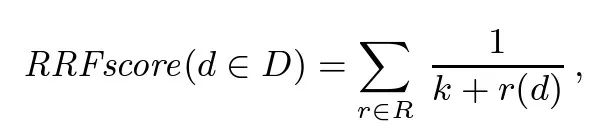

In [39]:
# STEP 1: create 5 similar user queries for RRF algo --> use OpenAI for better quality
from langchain_core.messages import HumanMessage
import ast

def generate_similar_search_queries(initial_query, documets):
    
    message = HumanMessage(
        content= f""" 
            You are a helpful search assistant. Your task is to generate four similar search queries in relation to the provided documents based on a single input query. 
            Always use provided output for your response. Be concise and constructive. Do not deviate from the context of the provided documents.
            

            Initial single input query: {initial_query}
            Documents: {documets}
            Output sturcture: ["{initial_query}", search query 1, search query 2, search query 3, search query 4]

        """,

    )
    response = oai.invoke([message])
    queries = ast.literal_eval(response.content)

    return queries


rff_queries = generate_similar_search_queries(initial_query=user_query,
                                           documets=relevant_docs)
rff_queries

['Which CO2 concentration was recorded in 1950-1958?',
 'What was the level of CO2 in the atmosphere between 1950 and 1958?',
 'What were the CO2 levels in the 1950s?',
 'What was the recorded CO2 concentration in the years 1950-1958?',
 'What was the atmospheric CO2 concentration in the period 1950-1958?']

In [40]:
# STEP 2: build dictionaries for retrieved results incl. simulations

def generate_simulated_results(simulated_queries:list):

    all_queries_results = {}

    for query in simulated_queries:
        results = db.similarity_search_with_score(query, k=4)
        all_queries_results[query] = results

    return all_queries_results

sim_results = generate_simulated_results(rff_queries)
sim_results.keys()

dict_keys(['Which CO2 concentration was recorded in 1950-1958?', 'What was the level of CO2 in the atmosphere between 1950 and 1958?', 'What were the CO2 levels in the 1950s?', 'What was the recorded CO2 concentration in the years 1950-1958?', 'What was the atmospheric CO2 concentration in the period 1950-1958?'])

In [41]:
# function to re-rank the search results into a unified result set

def reciprocal_rank_fusion(search_results_dict, k=5):
    """
    Applies reciprocal rank fusion on the provided search results dictionary.

    Args:
        search_results_dict (dict): A dictionary where each key is a query, and value is a list of (Document, score) tuples.
        k (int): The rank offset to apply in the reciprocal calculation.

    Returns:
        dict: A dictionary of documents (page content) with their fused scores and source, sorted in descending order of score.
    """
    fused_scores = {}

    for query, doc_scores in search_results_dict.items():
        for rank, (doc, score) in enumerate(sorted(doc_scores, key=lambda x: x[1], reverse=True)):
            doc_identifier = doc.page_content  # page content as unique identifier
            doc_source = doc.metadata.get('source', 'unknown')
            
            if doc_identifier not in fused_scores:
                fused_scores[doc_identifier] = [0, doc_source]
            
            # update the score
            fused_scores[doc_identifier][0] += 1 / (rank + k)

    # sort docs by fused score in descending order
    reranked_results = {doc: [score, source] for doc, (score, source) in sorted(fused_scores.items(), key=lambda x: x[1][0], reverse=True)}

    print(f"----- RE-RANKING -----\nDOCUMENTS RERANKED SUCCESSFULLY!")

    return reranked_results


reranked_results = reciprocal_rank_fusion(sim_results)
reranked_results

----- RE-RANKING -----
DOCUMENTS RERANKED SUCCESSFULLY!


{'Over the same time the \nconcentration of methane, the second most important greenhouse gas, has even risen by more than 150%.\n\nIn the absence of drastic measures to reduce emissions, the \natmospheric carbon dioxide concentration is expected to double even within the next \nfew decades (to almost 600 ppm, relative to pre-industrial level; IPCC, 2001).': [0.7142857142857142,
  'data/rag-agent-data\\umweltbundesamt.pdf'],
 '7\nThe concentration of CO2 in the atmosphere has risen  \ncontinuously over the last 60 years \n• The CO2 concentration has been directly measured on the Hawaiian volcano Mauna Loa since 1958.\n\nSince the measuring station is situated at a very high altitude (3397 m above sea level) and is hardly \nimpacted by local factors, the values recorded there are considered to be a good approximation of \nthe actual global CO2 concentration.\n\n• The concentration has been continuously increasing since researchers began taking measurements.\n\nIn March 2021, it had reac

## Generation

In [42]:
# take top 3 graded & re-ranked results

top3_reranked_results = dict(list(reranked_results.items())[:3])

In [43]:
# generate initial result

prompt = PromptTemplate(
    template="""
        You are an assistant for question-answering tasks. 
        Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. 
        Be as concise and as precise as possible. Use maximum of 400 completion tokens for your response.
        Question: {question} 
        Context: {context} 
        Answer: 
    """,
    input_variables=["question", "context"],
)

rag_chain = prompt | oai | StrOutputParser()

# chain
init_generation = rag_chain.invoke({"context": top3_reranked_results, "question": user_query})
print(init_generation)

The first measurement of CO2 concentration was taken in 1958 and recorded a concentration of about 316 ppm.


## Full Pipeline

In [ ]:
final_query = "Which years were selected for HadEX3 and why?"